# Harmony and STAC: PI 20.3 Demo

In PI 20.3, Harmony updated their service integrator's guide with improved guidance on transformation metadata to include in backend service outputs. In addition, we helped to ensure that the Harmony STAC catalog contains accurate spatial and temporal metadata representing the subsetted outputs produced by each backend service. 

This notebook provides a basic workflow to access Harmony outputs in-place from the s3 locations provided by the STAC catalog generated from an asynchronous request. For more a general introduction and tutorial, see [Harmony API Introduction](./Harmony%20Api%20Introduction.ipynb).  Useful helpers for making the calls found in this notebook can be found under the [docs/notebook-helpers](./notebook-helpers) folder.

## Prerequisites

#### You must run this notebook within an EC2 instance running in us-west-2:
1. Follow tutorials 01 through 03 of the [NASA Earthdata Cloud Primer](https://earthdata.nasa.gov/learn/user-resources/webinars-and-tutorials/cloud-primer) to set up an EC2 instance within us-west-2. Ensure you are also following step 3 in the ["Jupyter Notebooks on AWS EC2 in 12 (mostly easy) steps"](https://medium.com/@alexjsanchez/python-3-notebooks-on-aws-ec2-in-15-mostly-easy-steps-2ec5e662c6c6) article to set the correct security group settings needed to connect your local port to your EC2’s notebook port thru SSH.

2. Follow the remaining instructions in the Medium article above, which includes installation of Anaconda3 (including Jupyter Lab) in your ec2 instance. Before moving over to Jupyter Lab, perform steps 3 - 4 to set up Earthdata Login and Harmony access:

3. Setup your `~/.netrc` for Earthdata Login in your ec2 instance:

`machine uat.urs.earthdata.nasa.gov login <user> password <password>`

4. Run the following in your ec2 instance terminal window to generate short-term Harmony access keys:

`curl -Ln -bj https://harmony.uat.earthdata.nasa.gov/cloud-access.sh`

5. Set your environment variables based on the keys provided in step 4:

`export AWS_ACCESS_KEY_ID='...
export AWS_SECRET_ACCESS_KEY='...'
export AWS_DEFAULT_REGION='us-west-2'`

6. Once the notebook is running in Jupyter Lab, run the following cell to install Python dependencies, import necessary modules, and set notebook defaults:

In [2]:
%load_ext autoreload
%autoreload
%matplotlib inline

import sys
# Install dependencies into the Jupyter Kernel
!{sys.executable} -m pip install -q -r notebook_helpers/requirements.txt
#!{sys.executable} -m pip install intake-stac # if you don't already have intake-stac

# Import libraries used throughout the notebook
from notebook_helpers import get, post, show, get_data_urls, show_async, show_async_condensed, print_async_status, show_shape
import json
import intake
import s3fs

## ASF Data Transformations

The ASF gdal service provides subsetting, reformatting, and reprojection capabilities for ASF's Sentinel-1 Interferograms (BETA) product:

In [3]:
asf_collection = 'C1225776654-ASF'
coverages_root = 'https://harmony.uat.earthdata.nasa.gov/{collection}/ogc-api-coverages/1.0.0/collections/{variable}/coverage/rangeset'

### Variable and spatial subsetting with projecting, reformtatting output to PNG and spatial constraints
Each parent NetCDF is approx. 60 MB and the subsetted pngs and geotiffs are well under 1 MB each.

GET /C1225776654-ASF/ogc-api-coverages/1.0.0/collections/science%2Fgrids%2Fdata%2Fcoherence/coverage/rangeset?format=image%2Fpng&outputcrs=EPSG%3A2230&subset=lon%28-115.5%3A-115.25%29&subset=lat%2833%3A33.1%29&subset=time%28%222020-03-13T00%3A00%3A00Z%22%3A%222020-03-13T23%3A59%3A59Z%22%29
Async response at 02:44:49
{
  "username": "amy.steiker",
  "status": "running",
  "message": "The job is being processed",
  "progress": 0,
  "createdAt": "2020-09-29T02:44:49.853Z",
  "updatedAt": "2020-09-29T02:44:49.853Z",
  "links": [
    {
      "title": "Job Status",
      "href": "https://harmony.uat.earthdata.nasa.gov/jobs/719b703b-c185-4c01-982b-4de96406006f",
      "rel": "self",
      "type": "application/json"
    }
  ],
  "request": "https://harmony.uat.earthdata.nasa.gov/C1225776654-ASF/ogc-api-coverages/1.0.0/collections/science%2Fgrids%2Fdata%2Fcoherence/coverage/rangeset?format=image%2Fpng&outputcrs=EPSG%3A2230&subset=lon(-115.5%3A-115.25)&subset=lat(33%3A33.1)&subset=time(%222020-0

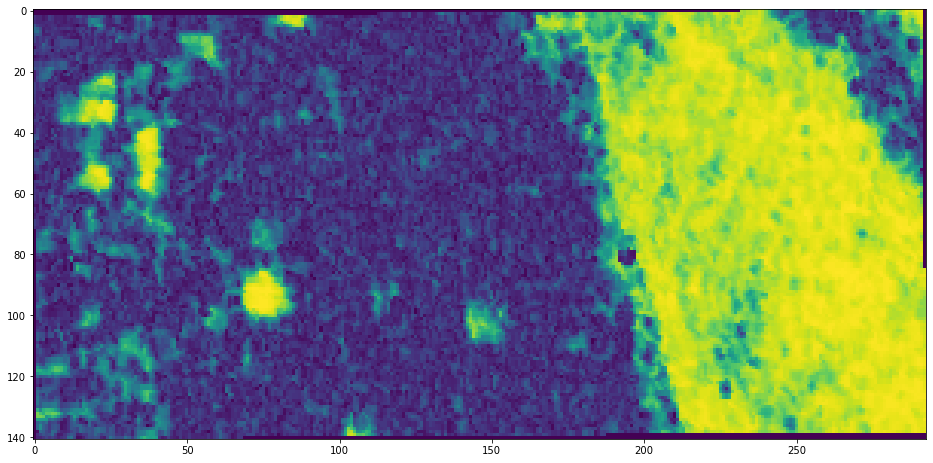

Waiting for updates...
Async response at 02:45:09
{
  "username": "amy.steiker",
  "status": "running",
  "message": "The job is being processed",
  "progress": 100,
  "createdAt": "2020-09-29T02:44:49.853Z",
  "updatedAt": "2020-09-29T02:45:09.295Z",
  "links": [
    {
      "title": "Job Status",
      "href": "https://harmony.uat.earthdata.nasa.gov/jobs/719b703b-c185-4c01-982b-4de96406006f",
      "rel": "self",
      "type": "application/json"
    },
    {
      "href": "https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/asfdataservices/gdal-subsetter/392ce640-5e30-47bc-b49b-702351161b59/S1-GUNW-A-R-166-tops-20200313_20200206-014119-34455N_32574N-PP-1749-v2_0_2_science_grids_data_coherence_regridded_subsetted.png",
      "title": "G1234646236-ASF",
      "type": "image/png",
      "rel": "data",
      "bbox": [
        -115.5012694,
        32.9986992,
        -115.2492896,
        33.1021816
      ],
      "temporal": {
        "start": "2020-03-13T0

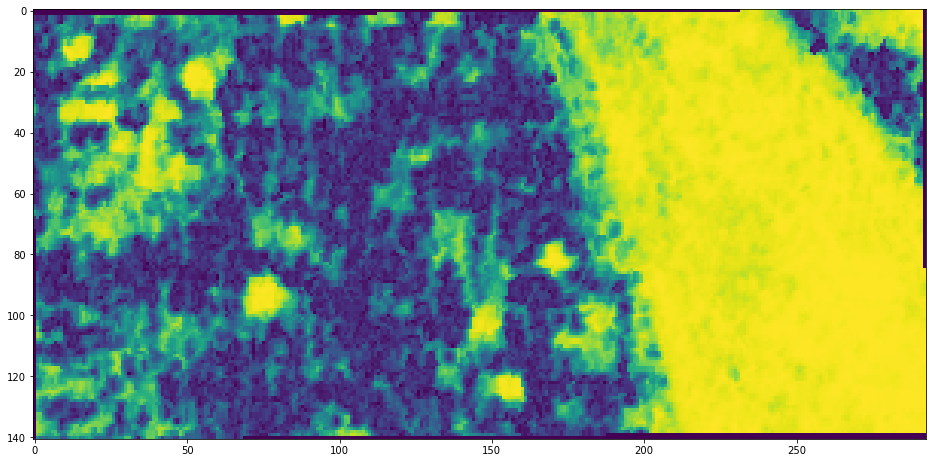

Waiting for updates...
Async response at 02:45:15
{
  "username": "amy.steiker",
  "status": "successful",
  "message": "The job has completed successfully",
  "progress": 100,
  "createdAt": "2020-09-29T02:44:49.853Z",
  "updatedAt": "2020-09-29T02:45:15.041Z",
  "links": [
    {
      "title": "Job Status",
      "href": "https://harmony.uat.earthdata.nasa.gov/jobs/719b703b-c185-4c01-982b-4de96406006f",
      "rel": "self",
      "type": "application/json"
    },
    {
      "title": "STAC catalog",
      "href": "https://harmony.uat.earthdata.nasa.gov/stac/719b703b-c185-4c01-982b-4de96406006f/",
      "rel": "stac-catalog-json",
      "type": "application/json"
    },
    {
      "href": "https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/asfdataservices/gdal-subsetter/392ce640-5e30-47bc-b49b-702351161b59/S1-GUNW-A-R-166-tops-20200313_20200206-014119-34455N_32574N-PP-1749-v2_0_2_science_grids_data_coherence_regridded_subsetted.png",
      "title": "G12

<Response [200]>

In [4]:
response = get(
    coverages_root.format(
        collection=asf_collection, 
        variable='science%2Fgrids%2Fdata%2Fcoherence'),
    params={
        'format': 'image/png',
        'outputcrs': 'EPSG:2230',
        'subset': [
            'lon(-115.5:-115.25)', 
            'lat(33:33.1)',
            'time("2020-03-13T00:00:00Z":"2020-03-13T23:59:59Z")'
            ]})

show_async(response)

## Explore the STAC response using `intake-stac`

Each asynchronous request response includes a [STAC](https://stacspec.org/) catalog that contains spatial and temporal metadata for each output, or STAC item. These metadata fields now reflect the values of the subsetted outputs themselves, providing transformation metadata for users. The [Pangeo gallery](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html) includes great guidance on how to work with stac catalogs to access cloud-hosted data in place.

#### Store job ID to create STAC location

In [5]:
results = json.loads(response.content)
job = results['jobID']
print(job)

stac_root = 'https://harmony.uat.earthdata.nasa.gov/stac/{jobID}/{item}'

719b703b-c185-4c01-982b-4de96406006f


#### Open STAC Catalog from Harmony async response

Two STAC items are listed, corresponding to the two outputs plotted above.

In [6]:
stac_cat = intake.open_stac_catalog(stac_root.format(jobID=job,item=''),name='Harmony output')
display(list(stac_cat))

['719b703b-c185-4c01-982b-4de96406006f_0',
 '719b703b-c185-4c01-982b-4de96406006f_1']

In [7]:
list(stac_cat)[0]

'719b703b-c185-4c01-982b-4de96406006f_0'

We can inspect the metadata of each STAC item, which includes the bounding box, coordinates, and start and end time:

In [8]:
for i in range(len(list(stac_cat))):
    display(intake.open_stac_item(stac_root.format(jobID=job,item=i)))

719b703b-c185-4c01-982b-4de96406006f_0:
  args:
    stac_obj: https://harmony.uat.earthdata.nasa.gov/stac/719b703b-c185-4c01-982b-4de96406006f/0
  description: ''
  driver: intake_stac.catalog.StacItem
  metadata:
    bbox:
    - -115.5012694
    - 32.9986992
    - -115.2492896
    - 33.1021816
    created: '2020-09-29T02:44:49.853Z'
    date: 2020-03-13
    datetime: 2020-03-13 01:41:06.357000+00:00
    end_datetime: '2020-03-13T01:41:33.312Z'
    geometry:
      coordinates:
      - - - -115.5012694
          - 32.9986992
        - - -115.5012694
          - 33.1021816
        - - -115.2492896
          - 33.1021816
        - - -115.2492896
          - 32.9986992
        - - -115.5012694
          - 32.9986992
      type: Polygon
    license: various
    start_datetime: '2020-03-13T01:41:06.357Z'


719b703b-c185-4c01-982b-4de96406006f_1:
  args:
    stac_obj: https://harmony.uat.earthdata.nasa.gov/stac/719b703b-c185-4c01-982b-4de96406006f/1
  description: ''
  driver: intake_stac.catalog.StacItem
  metadata:
    bbox:
    - -115.5012694
    - 32.9986992
    - -115.2492896
    - 33.1021816
    created: '2020-09-29T02:44:49.853Z'
    date: 2020-03-13
    datetime: 2020-03-13 13:43:35.505000+00:00
    end_datetime: '2020-03-13T13:44:02.462Z'
    geometry:
      coordinates:
      - - - -115.5012694
          - 32.9986992
        - - -115.5012694
          - 33.1021816
        - - -115.2492896
          - 33.1021816
        - - -115.2492896
          - 32.9986992
        - - -115.5012694
          - 32.9986992
      type: Polygon
    license: various
    start_datetime: '2020-03-13T13:43:35.505Z'


Each item can be accessed from the harmony s3 staging bucket:

In [9]:
entries = []
for id, entry in stac_cat.search('type').items():
    display(entry)
    entries.append(entry)

name: s3://harmony-uat-staging/public/asfdataservices/gdal-subsetter/392ce640-5e30-47bc-b49b-702351161b59/S1-GUNW-A-R-166-tops-20200313_20200206-014119-34455N_32574N-PP-1749-v2_0_2_science_grids_data_coherence_regridded_subsetted.png
container: xarray
plugin: ['xarray_image']
description: G1234646236-ASF
direct_access: True
user_parameters: []
metadata: 
  href: s3://harmony-uat-staging/public/asfdataservices/gdal-subsetter/392ce640-5e30-47bc-b49b-702351161b59/S1-GUNW-A-R-166-tops-20200313_20200206-014119-34455N_32574N-PP-1749-v2_0_2_science_grids_data_coherence_regridded_subsetted.png
  title: G1234646236-ASF
  type: image/png
  roles: ['overview']
args: 
  urlpath: s3://harmony-uat-staging/public/asfdataservices/gdal-subsetter/392ce640-5e30-47bc-b49b-702351161b59/S1-GUNW-A-R-166-tops-20200313_20200206-014119-34455N_32574N-PP-1749-v2_0_2_science_grids_data_coherence_regridded_subsetted.png
  chunks: 

name: s3://harmony-uat-staging/public/asfdataservices/gdal-subsetter/392ce640-5e30-47bc-b49b-702351161b59/S1-GUNW-D-R-173-tops-20200313_20200224-134348-34565N_32585N-PP-1b6a-v2_0_2_science_grids_data_coherence_regridded_subsetted.png
container: xarray
plugin: ['xarray_image']
description: G1234646241-ASF
direct_access: True
user_parameters: []
metadata: 
  href: s3://harmony-uat-staging/public/asfdataservices/gdal-subsetter/392ce640-5e30-47bc-b49b-702351161b59/S1-GUNW-D-R-173-tops-20200313_20200224-134348-34565N_32585N-PP-1b6a-v2_0_2_science_grids_data_coherence_regridded_subsetted.png
  title: G1234646241-ASF
  type: image/png
  roles: ['overview']
args: 
  urlpath: s3://harmony-uat-staging/public/asfdataservices/gdal-subsetter/392ce640-5e30-47bc-b49b-702351161b59/S1-GUNW-D-R-173-tops-20200313_20200224-134348-34565N_32585N-PP-1b6a-v2_0_2_science_grids_data_coherence_regridded_subsetted.png
  chunks: 

## Access Harmony outputs directly from STAC 

The Harmony output image is loaded up into an xarray data array directly from the STAC catalog.

In [10]:
da = stac_cat[list(stac_cat)[0]][entries[0].describe()['name']].to_dask()
da

<xarray.DataArray (y: 141, x: 293)>
dask.array<xarray-<this-array>, shape=(141, 293), dtype=uint8, chunksize=(141, 293), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 132 133 134 135 136 137 138 139 140
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 284 285 286 287 288 289 290 291 292

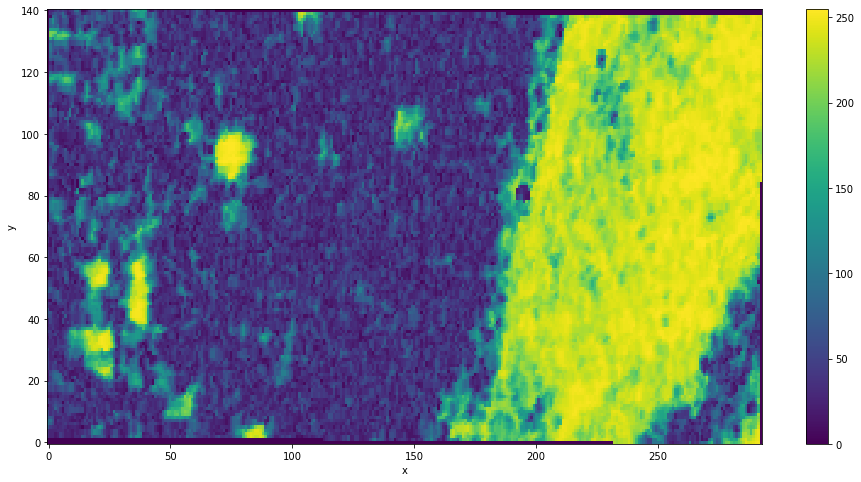

In [11]:
da.plot.imshow()

#### Compare to non subsetted granule

The STAC metadata reflect the native granule bounds for an equivalent request without spatial subsetting:

GET /C1225776654-ASF/ogc-api-coverages/1.0.0/collections/science%2Fgrids%2Fdata%2Fcoherence/coverage/rangeset?format=image%2Fpng&granuleID=G1234646236-ASF&outputcrs=EPSG%3A2230&forceAsync=true&subset=time%28%222020-03-13T00%3A00%3A00Z%22%3A%222020-03-13T23%3A59%3A59Z%22%29
Getting results for request
JobID: e360bf93-423a-4419-8125-7a21a2707d94 Status: running ( 0 %) Messages: The job is being processed
GET /service-results/harmony-uat-staging/public/asfdataservices/gdal-subsetter/d7a17a22-3856-42ff-aeba-33e45558ce1f/S1-GUNW-A-R-166-tops-20200313_20200206-014119-34455N_32574N-PP-1749-v2_0_2_science_grids_data_coherence_regridded.png


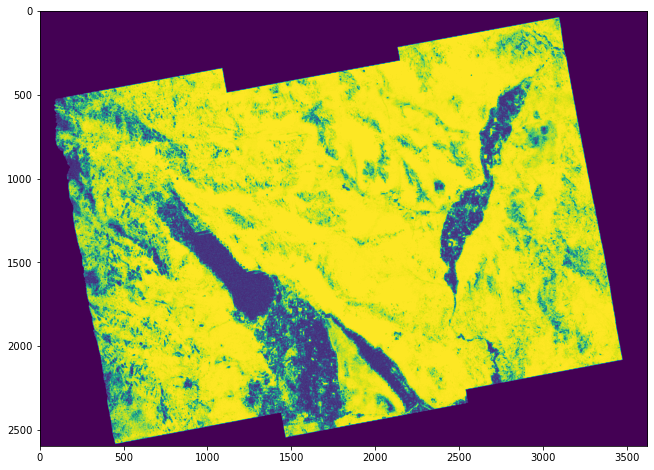

JobID: e360bf93-423a-4419-8125-7a21a2707d94 Status: running ( 100 %) Messages: The job is being processed
JobID: e360bf93-423a-4419-8125-7a21a2707d94 Status: successful ( 100 %) Messages: The job has completed successfully
Async request is complete


In [15]:
response_nosubset = get(
    coverages_root.format(
        collection=asf_collection, 
        variable='science%2Fgrids%2Fdata%2Fcoherence'),
    params={
        'format': 'image/png',
        'granuleID': 'G1234646236-ASF',
        'outputcrs': 'EPSG:2230',
        'forceAsync' : 'true',
        'subset': [
            'time("2020-03-13T00:00:00Z":"2020-03-13T23:59:59Z")'
            ]})
show_async_condensed(response_nosubset)

In [21]:
results_nosubset = json.loads(response_nosubset.content)
job_nosubset = results_nosubset['jobID']

stac_cat_nosubset = intake.open_stac_catalog(stac_root.format(jobID=job_nosubset,item=''),name='Harmony output')

display(intake.open_stac_item(stac_root.format(jobID=job_nosubset,item='0')))

e360bf93-423a-4419-8125-7a21a2707d94_0:
  args:
    stac_obj: https://harmony.uat.earthdata.nasa.gov/stac/e360bf93-423a-4419-8125-7a21a2707d94/0
  description: ''
  driver: intake_stac.catalog.StacItem
  metadata:
    bbox:
    - -116.8509047
    - 32.5464653
    - -113.6322356
    - 34.4808895
    created: '2020-09-29T02:51:34.413Z'
    date: 2020-03-13
    datetime: 2020-03-13 01:41:06.357000+00:00
    end_datetime: '2020-03-13T01:41:33.312Z'
    geometry:
      coordinates:
      - - - -116.8509047
          - 32.5464653
        - - -116.8509047
          - 34.4808895
        - - -113.6322356
          - 34.4808895
        - - -113.6322356
          - 32.5464653
        - - -116.8509047
          - 32.5464653
      type: Polygon
    license: various
    start_datetime: '2020-03-13T01:41:06.357Z'
